On this project i will use the method of the web scrapping in order to collect quotes from one site, once i have collected the quotes i will proceed with Natural Language Process (NLP).

Importing the libraries 

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import time


Create the function to scare the internet page in order to collect the data. Once the data are collected they are saved on a csv file for further analysis.

In [ ]:
def scrape_quotes():
    url = "https://quotes.toscrape.com"
    pages_to_scrape = 10 #number of pages to scrap
    page_count  = 0 
    
    with open('quotes_csv',mode='a',newline='',encoding='utf-8') as file:
        writer = csv.writer(file)
        
        if file.tell()==0:
            writer.writerow(['Quote','Author','Tgs'])
            
        while url and page_count<pages_to_scrape:
            response = requests.get(url)
            soup = BeautifulSoup(response.text,'html.parser')
            quotes=soup.find_all('div',class_='quote')
            for quote in quotes:
                text = quote.find('span',class_='text').get_text()
                author = quote.find('small',class_='author').get_text()
                tags = [tag.get_text() for tag in quote.find_all('a',class_='tag')]
                writer.writerow([text,author,', '.join(tags)])
            
            page_count +=1
            print(f"Data collected from the page {page_count}")
            next_button = soup.find('li',class_='next')
            if next_button:
                next_page_link = next_button.find('a')['href']
                url = "https://quotes.toscrape.com" + next_page_link
            else:
                url = None #there is no next page
                
            time.sleep(60)
            print("Data collection was completed")

scrape_quotes()

Import the data after the scape procees.

In [2]:
import pandas as pd

data = pd.read_csv("C:\\Users\\georg\\OneDrive\\Υπολογιστής\\Data Science Projects\\Web_Scrapping_NLP\\quotes_csv")
data.head()

,Quote,Author,Tgs
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational"


Data Preprocessing

In [6]:
#checking the shape of the dataset
data.shape

(100, 6)

In [7]:
#checking the data types of the columns
data.dtypes

Quote                object
Author               object
Tgs                  object
Cleaned_Quote        object
Tokens               object
Lemmatized_Tokens    object
dtype: object

In [8]:
#checking for null values
data.isnull().sum()

Quote                0
Author               0
Tgs                  3
Cleaned_Quote        0
Tokens               0
Lemmatized_Tokens    0
dtype: int64

In [9]:
#dealing with the missing values
data.dropna(subset=['Tgs'], inplace=True)
data.shape

(97, 6)

Exploratory Data Analysis - EDA

In [10]:
#checking the first 10 Authors with the most quotes
author_counts = data['Author'].value_counts()
print(author_counts.head(10))

Author
Albert Einstein     10
J.K. Rowling         8
Mark Twain           6
Marilyn Monroe       6
Dr. Seuss            6
Jane Austen          5
C.S. Lewis           5
Bob Marley           3
Suzanne Collins      2
Charles Bukowski     2
Name: count, dtype: int64


In [11]:
#checking the top 10 tags with the biggest frequency
tags_counts = data['Tgs'].str.split(', ').explode().value_counts()
print(tags_counts.head(10))

Tgs
love                    14
inspirational           13
life                    13
humor                   12
books                   11
reading                  7
friendship               5
truth                    4
friends                  4
attributed-no-source     3
Name: count, dtype: int64


In [12]:
#checking the pair of the tags with the highest frequency
from itertools import combinations
tags_combinations = data['Tgs'].str.split(', ').apply(lambda x: list(combinations(sorted(x),2)))
tags_comb_counts = tags_combinations.explode().value_counts()
print(tags_comb_counts.head(10))

Tgs
(books, reading)         4
(friendship, love)       3
(inspirational, life)    3
(inspirational, love)    2
(books, writing)         2
(life, yourself)         2
(life, love)             2
(books, friends)         2
(death, life)            2
(books, classic)         2
Name: count, dtype: int64


Natural Language Processing - NLP

1. Preprocessing

In [13]:
#importing the libraries 
import re
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

#create the function for cleaning the text from the quotes
def clean_text(text):
    
    #applying lowercase 
    text = text.lower()
    
    #removing 
    text = re.sub(r'[^a-z0-9\s]', '',text)
    
    #removing stepwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    #remove numbers
    text = re.sub(r'\d+', '',text)
    
    return text

#applying the function on the text

data['Cleaned_Quote'] = data['Quote'].apply(clean_text)
print(data['Cleaned_Quote'].head())
    

0    world created process thinking cannot changed ...
1               choices harry show truly far abilities
2    two ways live life one though nothing miracle ...
3    person gentleman lady pleasure good novel must...
4    imperfection beauty madness genius better abso...
Name: Cleaned_Quote, dtype: object


2. Tokenization 

In [14]:
from nltk.tokenize import word_tokenize
data['Tokens'] = data['Cleaned_Quote'].apply(word_tokenize)
print(data['Tokens'].head())

0    [world, created, process, thinking, can, not, ...
1        [choices, harry, show, truly, far, abilities]
2    [two, ways, live, life, one, though, nothing, ...
3    [person, gentleman, lady, pleasure, good, nove...
4    [imperfection, beauty, madness, genius, better...
Name: Tokens, dtype: object


3. Lemmatization 

In [27]:
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

data['Lemmatized_Tokens'] = data['Tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

print(data[['Tokens','Lemmatized_Tokens']].head())

                                              Tokens  \
0  [world, created, process, thinking, can, not, ...   
1      [choices, harry, show, truly, far, abilities]   
2  [two, ways, live, life, one, though, nothing, ...   
3  [person, gentleman, lady, pleasure, good, nove...   
4  [imperfection, beauty, madness, genius, better...   

                                   Lemmatized_Tokens  
0  [world, created, process, thinking, can, not, ...  
1         [choice, harry, show, truly, far, ability]  
2  [two, way, live, life, one, though, nothing, m...  
3  [person, gentleman, lady, pleasure, good, nove...  
4  [imperfection, beauty, madness, genius, better...  


Sentiment Analysis 

In [18]:
from textblob import TextBlob

#calculating the sentiment 
data['sentiment'] = data['Quote'].apply(lambda x: TextBlob(x).sentiment.polarity)

#classification of the sentiment
data['sentiment_label'] = data['sentiment'].apply(lambda x: 'Positive' if x>0 else ('Negative' if x<0 else 'Neutral'))

print(data[['Quote', 'sentiment', 'sentiment_label']].head())


                                               Quote  sentiment  \
0  “The world as we have created it is a process ...   0.000000   
1  “It is our choices, Harry, that show what we t...   0.300000   
2  “There are only two ways to live your life. On...   0.003788   
3  “The person, be it gentleman or lady, who has ...  -0.050000   
4  “Imperfection is beauty, madness is genius and...  -0.277778   

  sentiment_label  
0         Neutral  
1        Positive  
2        Positive  
3        Negative  
4        Negative  


<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment_label'>

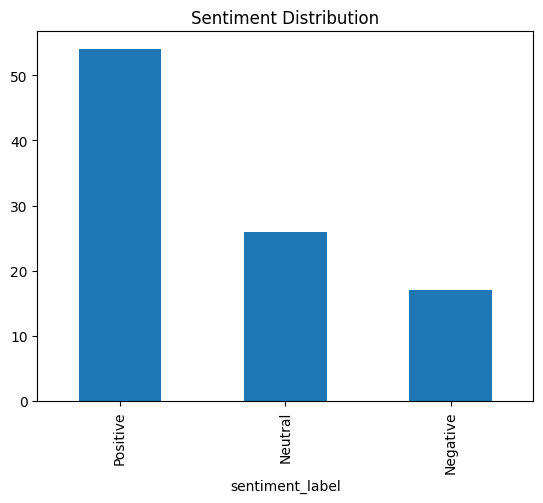

In [19]:
data['sentiment_label'].value_counts().plot(kind='bar', title='Sentiment Distribution')

Pie Chart

<Axes: title={'center': 'Sentiment Breakdown'}, ylabel='count'>

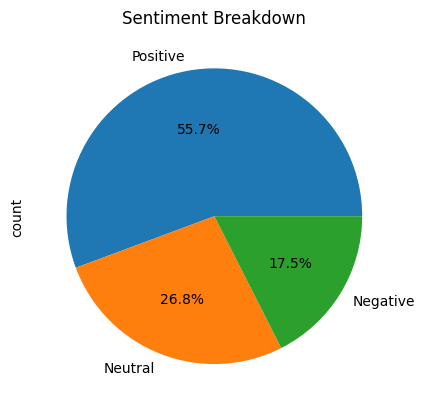

In [20]:
import matplotlib.pyplot as plt
data['sentiment_label'].value_counts().plot.pie(autopct='%1.1f%%', title='Sentiment Breakdown')

Top quotes per statment (positive & negative).

In [21]:
#top 3 positive quotes for positive sentement 
top_positive = data.nlargest(3,'sentiment')[['Quote','sentiment']]
print("Top Positive Quotes:\n",top_positive)

#top 3 negative quotes for positive sentement 
top_negative = data.nsmallest(3,'sentiment')[['Quote','sentiment']]
print("Top Positive Quotes:\n",top_negative)


Top Positive Quotes:
                                                 Quote  sentiment
18  “Good friends, good books, and a sleepy consci...   0.766667
29  “One good thing about music, when it hits you,...   0.700000
26  “If you want your children to be intelligent, ...   0.650000
Top Positive Quotes:
                                                 Quote  sentiment
71  “Some people never go crazy. What truly horrib...  -0.800000
55  “The difference between genius and stupidity i...  -0.600000
24  “Beauty is in the eye of the beholder and it m...  -0.322222


In [22]:
data.head()

,Quote,Author,Tgs,Cleaned_Quote,Tokens,Lemmatized_Tokens,sentiment,sentiment_label
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world",world created process thinking cannot changed ...,"[world, created, process, thinking, can, not, ...","[world, created, process, thinking, can, not, ...",0.000000,Neutral
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices",choices harry show truly far abilities,"[choices, harry, show, truly, far, abilities]","[choice, harry, show, truly, far, ability]",0.300000,Positive
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles",two ways live life one though nothing miracle ...,"[two, ways, live, life, one, though, nothing, ...","[two, way, live, life, one, though, nothing, m...",0.003788,Positive
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor",person gentleman lady pleasure good novel must...,"[person, gentleman, lady, pleasure, good, nove...","[person, gentleman, lady, pleasure, good, nove...",-0.050000,Negative
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational",imperfection beauty madness genius better abso...,"[imperfection, beauty, madness, genius, better...","[imperfection, beauty, madness, genius, better...",-0.277778,Negative
